<a href="https://colab.research.google.com/github/vrao9/google_colab/blob/master/mnist_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Auto-Encoder for mnist

In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
import random

Use random.seed() to generate the same result irrespective of the number of trials

In [2]:
random.seed(1)

# load the data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_size = x_train.shape[1]
orig_dim = img_size * img_size
x_train = np.reshape(x_train, [-1, orig_dim])
x_test = np.reshape(x_test, [-1, orig_dim])
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# network params
input_shape = (orig_dim,)
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

11493376/11490434 [==============================] - 1s 0us/step


## **Reparameterization technique:** 
Since samples are to be drawn randomly given mean and standard deviation, this process becomes stochastic and as a result the gradient rule cannot be used here to update them. In order to prevent such a thing from occuring, we use the reparameterization technique where the process of randomness is taken out of the model and the whole process becomes deterministic.
Here are some of the links which have tried to explain this concept:\\


1.   https://medium.com/@llionj/the-reparameterization-trick-4ff30fe92954
2.  https://math.stackexchange.com/questions/143186/derivative-of-a-random-variable-w-r-t-a-deterministic-variable
3.  https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important
4.  https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/




In [0]:
# helper functions
# reparameterization technique
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    eps = tf.random_normal(shape=(batch, dim))
    return eps * tf.exp(z_log_var * 0.5) + z_mean

In [0]:
class MLP_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(MLP_VAE, self).__init__()
    self.latent_dim = latent_dim
  
  # encoder model
  def encoder(self, input_img):  
    x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(input_img)
    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])                           
    encoder = tf.keras.models.Model(input_img, [z_mean, z_log_var, z], name='encoder')  
    return (z_mean, z_log_var, z, encoder)
  
  # decoder model
  def decoder(self, input_latent):
    x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(input_latent)
    output_img = tf.keras.layers.Dense(orig_dim, activation='sigmoid')(x)
    decoder = tf.keras.Model(input_latent, output_img, name='decoder')
    return decoder
  
  # combination of encoder and decoder
  def vae_model(self, input_img):
    output = self.decoder(self.encoder(input_img)[2])
    vae_model = tf.keras.Model(input_img, output)
    return (vae_model, output)

### Lantent dimension
Here the latent dimension is set to 2 (higher the number, the beter it is for reconstruction). It means, every digit is mapped into a space which consists of 2 pairs of mean and standard deviation. Since 2d is chosen, it can be easily visualised.

In [5]:
latent_dim = 2

input_img = Input(shape=input_shape, name='encoder_input')
input_latent = Input(shape=(latent_dim,), name='z_sampling')

vae = MLP_VAE(latent_dim)
z_mean, z_log_var, z, encoder = vae.encoder(input_img)
#encoder.summary()
decoder = vae.decoder(input_latent)
#decoder.summary()
outputs = decoder(encoder(input_img)[2])
vae_model = tf.keras.Model(input_img, outputs)
vae_model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


## Loss function
The loss function consists of 2 sub loss functions i.e. the KL divergence and the recontruction loss. KL divergence loss is minimum when the latent dim follows the unit guassian. And the reconstruction loss is minimum when the image reconstructed from the latent space fully match the input image.
### Binary cross entropy 
Returns the mean loss and hence here we have multiplied the loss with the dimension of the single image.

In [0]:
def my_loss(input_img, outputs, z_log_var, z_mean):
  reconstruction_loss = tf.keras.losses.binary_crossentropy(input_img, outputs)
  reconstruction_loss *= orig_dim                                                           
  kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) \
            - tf.keras.backend.exp(z_log_var)
  #kl loss at this point will be (batch_dim, latent_dim)  
  kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  return reconstruction_loss + kl_loss

In [7]:
vae_loss = tf.keras.backend.mean(my_loss(input_img, outputs, z_log_var, z_mean))
vae_model.add_loss(vae_loss)
vae_model.compile(optimizer='adam')
vae_model.summary()
vae_model.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
vae_model.save_weights('vae_mlp.mnist.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 100us/step - loss: 196.9439 - val_loss: 171.3496
Epoch 2/50
60000/60000 [==============================] - 4s 66us/step - loss: 168.5061 - val_loss: 166.2153
Epoch 3/50
60000/60000 [==============================] - 4s 66us/step - loss: 164.6434 - val_loss: 163.5909
Epoch 4/50
60000/60000

### Getting a general idea of the latent dimension
Here you will notice that each image corresponds to 2 pairs of mean and standard deviations.

In [8]:
# get the output of the encoder for the test data
z_mean,z_log_var,_ = encoder.predict(x_test, batch_size = batch_size)
print(z_mean.shape)
print(z_log_var.shape)

(10000, 2)
(10000, 2)


### Plotting the z-mean
Since the latent dim is 2D, its plotted on the scatter plot. You will notice that numbers which are having the same classes, are grouped together. Since we have minimised the KL loss between the latent distribution and the unit gaussian distribution, the z-mean will be located around 0 with a low standard deviation.

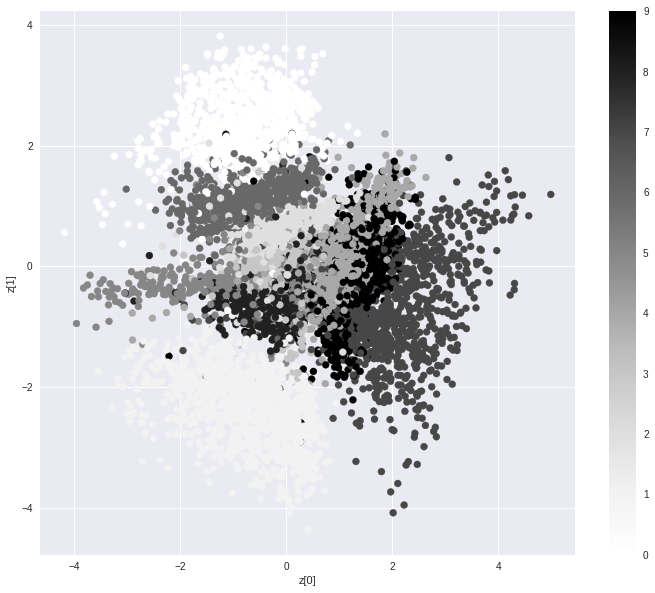

In [9]:
# since the z_mean is 2 dim, scatter plot is created
#z_mean, z_log_var, z, encoder = vae.encoder(input_img)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

### Generate the image for a given pair of sample
Looking at the above graph, it's possible to choose the coordinates for a given point and generate numbers using the decoder corresponding to that point.

(1, 2)
(1, 784)


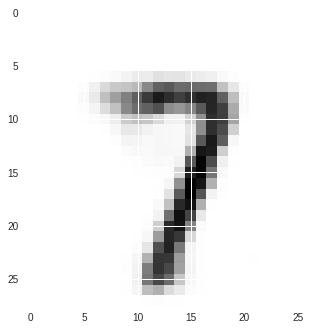

In [11]:
# location (z[0], z[1]) can be set for z_sample
z_sample = np.array([[2, -2]])
print(z_sample.shape)
img = decoder.predict(z_sample)
print(img.shape)
plt.imshow(img.reshape(28,28))
plt.show()